In [1]:
prefix="../../h2o-3"
import sys
sys.path.append(prefix + "/h2o-py/build/main")
import h2o
from h2o.estimators import H2OAdaBoostEstimator, H2OGradientBoostingEstimator
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

versionFromGradle='3.43.0',projectVersion='3.43.0.99999',branch='valenad-6723-adaboost-API',lastCommitHash='d58b1c3ef068a0feec1c49661dd49e9279b33d68',gitDescribe='jenkins-master-6264-18-gd58b1c3ef0',compiledOn='2023-09-11 15:31:47',compiledBy='potte'


In [2]:
# Notebook parameters

seed = 1234
n_estimators = 200
attempt_per_thread = 10 # number of runs of the algorithm in the thread
threds = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [3]:
def train_models(nthreads, file, target):
    h2o.init(nthreads=nthreads)
    train = h2o.import_file(file)
    train[target] = train[target].asfactor()
    global N
    N = train.shape[0]
    global P 
    P = train.shape[1]
    start = time.time()
    adaBoost_h2o = H2OAdaBoostEstimator(model_id = "adaboost.hex",
                                         n_estimators = n_estimators, seed = seed)
    adaBoost_h2o.train(training_frame = train, y=target)
    end = time.time()
    adaboost_time = end - start
    print(f"AdaBoost Time: {adaboost_time}s")
    start = time.time()
    gbm_h2o = H2OGradientBoostingEstimator(model_id = "adaboost.hex",
                                         ntrees = n_estimators, max_depth=2, score_tree_interval=n_estimators+1)
    gbm_h2o.train(training_frame = train, y=target)
    end = time.time()
    gbm_time = end - start
    print(f"GBM Time: {gbm_time}s")    
    h2o.cluster().shutdown()
    time.sleep(3)
    return adaboost_time, gbm_time


def run_benchmark(file, target):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        for i in range(attempt_per_thread):
            eif_time, if_time = train_models(nthreads, file, target)
            times_eif.append(eif_time)
            times_if.append(if_time)
        print(f"AdaBoost {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - AdaBoost {np.mean(times_eif)}s and GBM {np.mean(times_if)}s")

    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - AdaBoost = {np.mean(all_times_num_eif[i])}, GBM = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])
    
    return eif_means, if_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="AdaBoost", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"AdaBoost - training benchmark\nModel: N = {N}; P = {P}; n_estimatos = {n_estimators};")
    plt.savefig(f"h2o-scale-perf_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [4]:
adaboost_time, gbm_time = run_benchmark(prefix + "/smalldata/prostate/prostate.csv", "CAPSULE")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeswg93ck
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeswg93ck\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeswg93ck\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_rnprfm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.0032455921173096s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48196864128112793s
H2O session _sid_8319 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz1o3p2iu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz1o3p2iu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz1o3p2iu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_e7tpg2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9344370365142822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.501340389251709s
H2O session _sid_8cf9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf39lmd9p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf39lmd9p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf39lmd9p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_hh7b9j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.973573923110962s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48558712005615234s
H2O session _sid_9e94 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe_89bh2x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe_89bh2x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe_89bh2x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_mdjj6l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.956751823425293s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.47914671897888184s
H2O session _sid_896b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxzft_cie
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxzft_cie\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxzft_cie\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_dah2zu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9576303958892822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.501197099685669s
H2O session _sid_99c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplg1j2pe5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplg1j2pe5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplg1j2pe5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_2fgqvp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.958240032196045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4856696128845215s
H2O session _sid_92fd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4qspews
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4qspews\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4qspews\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_h8l7cd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9664769172668457s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48563671112060547s
H2O session _sid_84b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3e5yde_e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3e5yde_e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3e5yde_e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_k4q8jt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9730546474456787s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48494696617126465s
H2O session _sid_b7f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqu7x9vg3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqu7x9vg3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqu7x9vg3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_74mvvh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.352698802947998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48554372787475586s
H2O session _sid_9ead closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwb74qmz9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwb74qmz9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwb74qmz9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_slg8u9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.374113082885742s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.500840425491333s
H2O session _sid_bc06 closed.
AdaBoost 2.045022225379944s
IF 0.4891877412796021s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv99sfakl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv99sfakl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv99sfakl\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_s1ie06
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3215363025665283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5011394023895264s
H2O session _sid_b514 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu_7xhm3g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu_7xhm3g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu_7xhm3g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_dfg39f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9731221199035645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4790780544281006s
H2O session _sid_b469 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprz4988t_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprz4988t_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprz4988t_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_6s8by4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.941929578781128s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48558473587036133s
H2O session _sid_b42c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfj8o1e3u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfj8o1e3u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfj8o1e3u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_zpph91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9351515769958496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5168213844299316s
H2O session _sid_b0fa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2yj7hvlw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2yj7hvlw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2yj7hvlw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_vk3fq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.321355104446411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.485576868057251s
H2O session _sid_8823 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp118wx44c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp118wx44c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp118wx44c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_r3limt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9170894622802734s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48594021797180176s
H2O session _sid_b605 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbm__zzed
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbm__zzed\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbm__zzed\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_plqi59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9671924114227295s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4853515625s
H2O session _sid_b323 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl69c28_5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl69c28_5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl69c28_5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_jazw7h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9724907875061035s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5013253688812256s
H2O session _sid_b2e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg3p8w33g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg3p8w33g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg3p8w33g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_ka8a0s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9354150295257568s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4856529235839844s
H2O session _sid_9ecc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphlpc_uz_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphlpc_uz_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphlpc_uz_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_vbe49c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9600090980529785s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4546775817871094s
H2O session _sid_b97c closed.
AdaBoost 2.024529147148132s
IF 0.4881148099899292s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph037rlfe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph037rlfe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph037rlfe\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_tfic8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9582340717315674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4699289798736572s
H2O session _sid_a57d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmitg_ta3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmitg_ta3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmitg_ta3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_53qwo5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.359246015548706s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46999049186706543s
H2O session _sid_bd74 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprbs8v9bm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprbs8v9bm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprbs8v9bm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_lesh3k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.967160701751709s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4697890281677246s
H2O session _sid_b886 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphoxn49o4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphoxn49o4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphoxn49o4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_epmdhm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.937204360961914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4970712661743164s
H2O session _sid_9b89 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ig7r4mv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ig7r4mv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ig7r4mv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_jvm128
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9729833602905273s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48575711250305176s
H2O session _sid_a1a5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1zw6a70k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1zw6a70k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1zw6a70k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_2vo03v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9578561782836914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.469789981842041s
H2O session _sid_adab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxcjwv1gc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxcjwv1gc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxcjwv1gc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_w0q5np
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3614044189453125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.459913969039917s
H2O session _sid_8755 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbf8ybc1h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbf8ybc1h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbf8ybc1h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_tgqni0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3452630043029785s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4854114055633545s
H2O session _sid_9e69 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3te02whm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3te02whm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3te02whm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_ddp7p6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.320448160171509s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4697279930114746s
H2O session _sid_ad66 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg9dlq1bj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg9dlq1bj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg9dlq1bj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_mhsubr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3584322929382324s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4632699489593506s
H2O session _sid_a2b0 closed.
AdaBoost 2.1538232564926147s
IF 0.4740650177001953s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfohpaz86
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfohpaz86\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfohpaz86\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_8itmi0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.336620330810547s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48557162284851074s
H2O session _sid_81ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp9pqdt5t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp9pqdt5t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp9pqdt5t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_3trzbf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3112707138061523s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4792313575744629s
H2O session _sid_8e31 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiw57nba8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiw57nba8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiw57nba8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_ko6efe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.383263111114502s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4695923328399658s
H2O session _sid_b77d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphbkcy5ke
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphbkcy5ke\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphbkcy5ke\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_g1tfbg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3311715126037598s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4852926731109619s
H2O session _sid_b688 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnbn_8k95
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnbn_8k95\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnbn_8k95\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_6eliwr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9732341766357422s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.501234769821167s
H2O session _sid_b6f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpve8dgaxx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpve8dgaxx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpve8dgaxx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_rzrm6l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3516714572906494s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48538875579833984s
H2O session _sid_86e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpamo5z9d3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpamo5z9d3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpamo5z9d3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_9ythx0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3584699630737305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.49445390701293945s
H2O session _sid_a2b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm3em0nzz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm3em0nzz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm3em0nzz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_lz58mn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3050365447998047s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5011985301971436s
H2O session _sid_96e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppwe8takk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppwe8takk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppwe8takk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_62xsyd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9731626510620117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46349120140075684s
H2O session _sid_a587 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpypgypf41
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpypgypf41\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpypgypf41\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_vzhliu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.342040777206421s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5004913806915283s
H2O session _sid_b3a4 closed.
AdaBoost 2.266594123840332s
IF 0.4865946531295776s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpts49jm8_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpts49jm8_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpts49jm8_\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_yqqgqs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.706573724746704s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48558950424194336s
H2O session _sid_94d0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4py4m133
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4py4m133\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4py4m133\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_uma0vq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.367586135864258s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855930805206299s
H2O session _sid_aa57 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmp0tgutv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmp0tgutv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmp0tgutv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_jva1un
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9734041690826416s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48560428619384766s
H2O session _sid_b64d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu64hqn8k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu64hqn8k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu64hqn8k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_fi0dc9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.304567337036133s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4791438579559326s
H2O session _sid_a4df closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0zg4idix
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0zg4idix\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0zg4idix\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_nqnxbt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3586316108703613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012590885162354s
H2O session _sid_953c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbyv369zh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbyv369zh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbyv369zh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_715epm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.343126058578491s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46309947967529297s
H2O session _sid_bb33 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfzv2pxor
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfzv2pxor\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfzv2pxor\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_dnc9ry
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9512579441070557s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012834072113037s
H2O session _sid_a33a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo4cq766_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo4cq766_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo4cq766_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_2qbw0d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9667532444000244s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46996188163757324s
H2O session _sid_9a5d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpze5oxkgc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpze5oxkgc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpze5oxkgc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_er01fe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9733619689941406s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5009012222290039s
H2O session _sid_aff9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdhnee80d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdhnee80d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdhnee80d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_hwjtpe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9356188774108887s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46997594833374023s
H2O session _sid_baa8 closed.
AdaBoost 2.1880881071090696s
IF 0.4842411756515503s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpakdop8mg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpakdop8mg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpakdop8mg\h2o_potte_started_from_python.err
  Server is running at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_c7vmc8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.95133638381958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012283325195312s
H2O session _sid_b79f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgydkoggt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgydkoggt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgydkoggt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_7iiznl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9043693542480469s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46969079971313477s
H2O session _sid_acd7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp57fn6_xw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp57fn6_xw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp57fn6_xw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_lq2igp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9731404781341553s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012454986572266s
H2O session _sid_9cf8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8nfda3sx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8nfda3sx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8nfda3sx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_ygcm62
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9891021251678467s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855210781097412s
H2O session _sid_ba3a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpagvn1h_g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpagvn1h_g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpagvn1h_g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_db3v72
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9889986515045166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012075901031494s
H2O session _sid_b7b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxi94uoge
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxi94uoge\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxi94uoge\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_bhpxz4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9189629554748535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4856536388397217s
H2O session _sid_8f2d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp95s69q_w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp95s69q_w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp95s69q_w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_tlg607
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9576222896575928s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48560476303100586s
H2O session _sid_9f45 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplr_zydf3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplr_zydf3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplr_zydf3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_bcufkm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.990701675415039s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4960598945617676s
H2O session _sid_9080 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpokqvtexq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpokqvtexq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpokqvtexq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_g16eul
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.966817855834961s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.47005438804626465s
H2O session _sid_8ba7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphchsnl6w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphchsnl6w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphchsnl6w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_nzbop5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.382617712020874s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4694654941558838s
H2O session _sid_a025 closed.
AdaBoost 2.0023669481277464s
IF 0.48657314777374266s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwesks31l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwesks31l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwesks31l\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_mata7c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3673653602600098s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4699671268463135s
H2O session _sid_a02f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7z7ky1cn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7z7ky1cn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7z7ky1cn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_kmczqt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.358694314956665s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.501206636428833s
H2O session _sid_9a17 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwv80vg9z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwv80vg9z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwv80vg9z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_qmsxb7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3743808269500732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5168559551239014s
H2O session _sid_8285 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpumg6w4wx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpumg6w4wx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpumg6w4wx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_8z6beg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.345475912094116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.49151158332824707s
H2O session _sid_8cdc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4owgo9fq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4owgo9fq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4owgo9fq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_em0gdy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3580589294433594s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4790689945220947s
H2O session _sid_b420 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp39ksbvzl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp39ksbvzl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp39ksbvzl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_bsuqck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3521039485931396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855687618255615s
H2O session _sid_9fd5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1_v7ojsp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1_v7ojsp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1_v7ojsp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_6fgowl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.8289453983306885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48521947860717773s
H2O session _sid_a0a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpenb0i9p0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpenb0i9p0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpenb0i9p0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_yg8qil
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.2740018367767334s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5165755748748779s
H2O session _sid_ab48 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfj1yyvdn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfj1yyvdn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfj1yyvdn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_gwzlb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3676671981811523s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46994543075561523s
H2O session _sid_a61a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ia_pngi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ia_pngi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ia_pngi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_f4jthr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3579609394073486s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.478534460067749s
H2O session _sid_9681 closed.
AdaBoost 2.398465466499329s
IF 0.4894454002380371s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqo1c9f1m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqo1c9f1m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqo1c9f1m\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_k9c95m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.342332601547241s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4634568691253662s
H2O session _sid_9d7b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpac77govv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpac77govv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpac77govv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_okrgj4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.373483419418335s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48525476455688477s
H2O session _sid_90ae closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpadf7t1xr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpadf7t1xr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpadf7t1xr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_sodtba
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.321087598800659s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48557114601135254s
H2O session _sid_b941 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpweji_rx9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpweji_rx9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpweji_rx9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_devt67
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3272504806518555s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5168421268463135s
H2O session _sid_bb85 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8157g9_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8157g9_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8157g9_6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_89six5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3431692123413086s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5167286396026611s
H2O session _sid_a910 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppphloy6d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppphloy6d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppphloy6d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_s0agwl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3210196495056152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.501025915145874s
H2O session _sid_ab57 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0g1ga6pg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0g1ga6pg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0g1ga6pg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_ms9dag
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.957240343093872s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855666160583496s
H2O session _sid_b61e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8f97ahfh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8f97ahfh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8f97ahfh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_7a08vu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9889206886291504s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48566365242004395s
H2O session _sid_abf9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx5r8292g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx5r8292g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx5r8292g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_dpdkwk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.342883348464966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4696521759033203s
H2O session _sid_8fad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpteulohsq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpteulohsq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpteulohsq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_2d3oa3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9353458881378174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48557257652282715s
H2O session _sid_99cf closed.
AdaBoost 2.225273323059082s
IF 0.48953344821929934s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxs8yudg4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxs8yudg4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxs8yudg4\h2o_potte_started_from_python.err
  Server is running at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_nk4oul
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3835971355438232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855780601501465s
H2O session _sid_8823 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsu9kcknr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsu9kcknr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsu9kcknr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_r2g9pl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9363336563110352s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46994662284851074s
H2O session _sid_b723 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbv7ht1iz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbv7ht1iz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbv7ht1iz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_uwk9if
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3669416904449463s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855778217315674s
H2O session _sid_a1cb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw9eyynm2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw9eyynm2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw9eyynm2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_zvyv4v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.383124828338623s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48560285568237305s
H2O session _sid_ac83 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ovuz3hw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ovuz3hw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ovuz3hw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_nrcfc0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9670472145080566s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4856252670288086s
H2O session _sid_908c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpct3_br1f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpct3_br1f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpct3_br1f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,3 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_u2xs4v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3202710151672363s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4847984313964844s
H2O session _sid_9150 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpli5w93yz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpli5w93yz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpli5w93yz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours
H2O_cluster_name:,H2O_from_python_potte_m3a45o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3425087928771973s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4848153591156006s
H2O session _sid_a3a5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9hro2tau
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9hro2tau\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9hro2tau\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours
H2O_cluster_name:,H2O_from_python_potte_cktx23
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.353152275085449s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4991719722747803s
H2O session _sid_9b5a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0nddddu6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0nddddu6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0nddddu6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_avzo7r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3364689350128174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4539928436279297s
H2O session _sid_995a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp202try2r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp202try2r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp202try2r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_rmsuj7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.342940092086792s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5168864727020264s
H2O session _sid_8a78 closed.
AdaBoost 2.2732385635375976s
IF 0.48519957065582275s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2h6wux4a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2h6wux4a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2h6wux4a\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_hlkfvx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.367295503616333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855823516845703s
H2O session _sid_a59f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvab87eve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvab87eve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvab87eve\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_c9ksne
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3205068111419678s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5008876323699951s
H2O session _sid_817f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmbwrte3d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmbwrte3d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmbwrte3d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_4y6ibd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.1911258697509766s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4996981620788574s
H2O session _sid_9602 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpamzenphs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpamzenphs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpamzenphs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_jtaz9u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3587019443511963s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.485567569732666s
H2O session _sid_bdd2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpex8asgbo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpex8asgbo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpex8asgbo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_82gpbv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.2738380432128906s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46985459327697754s
H2O session _sid_971e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnn42jnaz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnn42jnaz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnn42jnaz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_qaoqnv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9954562187194824s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4854707717895508s
H2O session _sid_9f37 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp14ty1bwa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp14ty1bwa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp14ty1bwa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_h3ngtg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.7843611240386963s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855690002441406s
H2O session _sid_9638 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2mn5lc3n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2mn5lc3n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2mn5lc3n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_ot22ol
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3271536827087402s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5011119842529297s
H2O session _sid_9c7d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxpjfzoae
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxpjfzoae\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxpjfzoae\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_whgg01
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.342716693878174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5011959075927734s
H2O session _sid_bfc0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzjd26d1g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzjd26d1g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzjd26d1g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_r4dnhe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.358447551727295s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5008437633514404s
H2O session _sid_91ea closed.
AdaBoost 2.331960344314575s
IF 0.49157817363739015s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp43_sl7s5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp43_sl7s5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp43_sl7s5\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_va44xt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3055596351623535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5166096687316895s
H2O session _sid_b0b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyac45mxj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyac45mxj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyac45mxj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_oufmhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3052585124969482s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012028217315674s
H2O session _sid_b88a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps1sqfr9t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps1sqfr9t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps1sqfr9t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_5ck6y7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9891026020050049s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.47916507720947266s
H2O session _sid_891d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsld1yl1l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsld1yl1l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsld1yl1l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_nuxntw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9882514476776123s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48485708236694336s
H2O session _sid_b496 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpujc1rheb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpujc1rheb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpujc1rheb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_7zu19d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.982696533203125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.46994447708129883s
H2O session _sid_aa7e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplbc3rxs7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplbc3rxs7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplbc3rxs7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ci6mbf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9351701736450195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5013439655303955s
H2O session _sid_848a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjvgjufkn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjvgjufkn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjvgjufkn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_vk65xm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.0058391094207764s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4914686679840088s
H2O session _sid_85a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf_af9_4z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf_af9_4z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf_af9_4z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_7dny6u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9362733364105225s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4696810245513916s
H2O session _sid_812e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdgqnnxfu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdgqnnxfu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdgqnnxfu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_93rwyd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9351913928985596s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4700467586517334s
H2O session _sid_8015 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf0nma9_y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf0nma9_y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf0nma9_y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_dl15hc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.935584306716919s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.47008228302001953s
H2O session _sid_a7e5 closed.
AdaBoost 2.031892704963684s
IF 0.48544018268585204s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdpf7794u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdpf7794u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdpf7794u\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_prvv2e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3584072589874268s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48557162284851074s
H2O session _sid_8140 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8_9g2m74
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8_9g2m74\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8_9g2m74\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_uo5y8p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.372854709625244s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48520469665527344s
H2O session _sid_8ab5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp51rhgwiy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp51rhgwiy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp51rhgwiy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_n1i2yl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.9736952781677246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4854776859283447s
H2O session _sid_a818 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpla9dxf1u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpla9dxf1u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpla9dxf1u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_kczil3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3587703704833984s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4788973331451416s
H2O session _sid_9ace closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvxzizest
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvxzizest\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvxzizest\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_dq035o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.973146677017212s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48550844192504883s
H2O session _sid_b445 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_e_5bx2s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_e_5bx2s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_e_5bx2s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_a29udm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.353951930999756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5012342929840088s
H2O session _sid_85e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpegtfct5i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpegtfct5i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpegtfct5i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_cq1ivi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.989039659500122s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.48557567596435547s
H2O session _sid_9495 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkvkyc_y0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkvkyc_y0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkvkyc_y0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_j8vrju
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.2893552780151367s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.516817569732666s
H2O session _sid_a44a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqn4ag9p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqn4ag9p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcqn4ag9p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_ood3ya
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3209753036499023s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5007915496826172s
H2O session _sid_bf32 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpik4dcta4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpik4dcta4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpik4dcta4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_lxsg69
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 2.3580169677734375s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.47908592224121094s
H2O session _sid_ad81 closed.
AdaBoost 2.234821343421936s
IF 0.4904164791107178s
12 - AdaBoost = 2.045022225379944, GBM = 0.4891877412796021
11 - AdaBoost = 2.024529147148132, GBM = 0.4881148099899292
10 - AdaBoost = 2.1538232564926147, GBM = 0.4740650177001953
9 - AdaBoost = 2.266594123840332, GBM = 0.4865946531295776
8 - AdaBoost = 2.1880881071090696, GBM = 0.4842411756515503
7 - AdaBoost = 2.0023669481277464, GBM = 0.48657314777374266
6 - AdaBoost = 2.398465466499329, GBM = 0.4894454002380371
5 - AdaBoost = 2.225273323059082, GBM = 0.48953344821929934
4 - AdaBoost = 2.2732385635375976, GBM = 0.48519957065582275
3 - AdaBoost = 2.3319603443

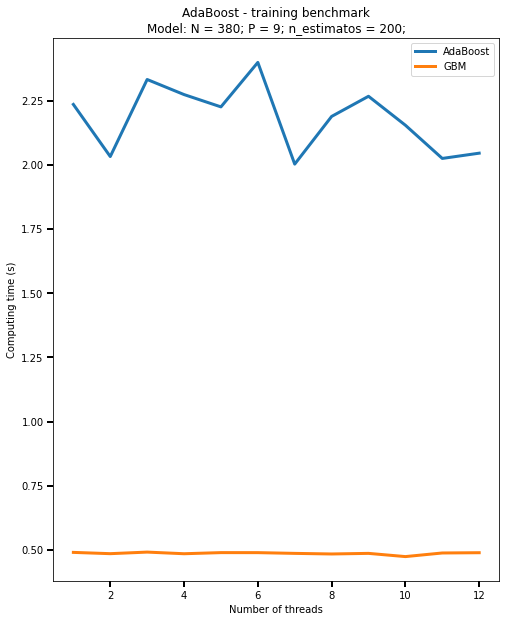

In [5]:
plot_result(adaboost_time, gbm_time)

In [6]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/higgs_head_2M.csv", "C1")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpapmgp_mo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpapmgp_mo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpapmgp_mo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_o660qd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.72523736953735s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.592125415802s
H2O session _sid_9399 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph7gug5w2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph7gug5w2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph7gug5w2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_tj7tbf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.310115814208984s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.316821575164795s
H2O session _sid_aa39 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjunsip4i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjunsip4i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjunsip4i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_pzrp9o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.18712639808655s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.13197612762451s
H2O session _sid_922a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr724o7uf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr724o7uf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr724o7uf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_yrsnjb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.46841645240784s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.03558349609375s
H2O session _sid_8b2e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ako7y9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ako7y9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ako7y9k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_328dix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.874878883361816s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.34025979042053s
H2O session _sid_839a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu4en9tm4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu4en9tm4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu4en9tm4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_vq1mu6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.35450625419617s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.63619065284729s
H2O session _sid_92ae closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpza4gxuww
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpza4gxuww\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpza4gxuww\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_ds84z0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.0954270362854s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.1957106590271s
H2O session _sid_9c37 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnt36t_cv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnt36t_cv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnt36t_cv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_mfi4zr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.15697479248047s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.146960735321045s
H2O session _sid_999b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcznq6lab
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcznq6lab\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcznq6lab\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_mhj996
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.19737148284912s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.15230631828308s
H2O session _sid_a035 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2dfeq5ru
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2dfeq5ru\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2dfeq5ru\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_na252m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.427703619003296s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.74127149581909s
H2O session _sid_8a44 closed.
AdaBoost 50.879775810241696s
IF 36.92892062664032s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprtnuhlv3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprtnuhlv3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprtnuhlv3\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_4lh02a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.53372097015381s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.6072735786438s
H2O session _sid_a752 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfb0kzxlg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfb0kzxlg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfb0kzxlg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_et3saq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.15053200721741s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.318365812301636s
H2O session _sid_b727 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpto5dqnqm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpto5dqnqm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpto5dqnqm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_k77pg8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.423914670944214s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.88087725639343s
H2O session _sid_96ec closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps97nplu5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps97nplu5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps97nplu5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_rv5dqu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.333213329315186s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.71263098716736s
H2O session _sid_94f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppihr6lhc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppihr6lhc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppihr6lhc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_hjxyfc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.9020893573761s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.87137961387634s
H2O session _sid_ba55 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgjqjyi_b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgjqjyi_b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgjqjyi_b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_xyyopy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.088565826416016s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.33911848068237s
H2O session _sid_9d24 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmg6ocvnb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmg6ocvnb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmg6ocvnb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_daqgss
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.40323758125305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.41629481315613s
H2O session _sid_a300 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7an6obqx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7an6obqx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7an6obqx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_xpjvh1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.520429611206055s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.41500186920166s
H2O session _sid_8f8b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq0i2gu39
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq0i2gu39\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq0i2gu39\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_pj783h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.39794611930847s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.104814291000366s
H2O session _sid_99d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppnc62j6o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppnc62j6o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppnc62j6o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_0d4iht
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.344117164611816s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.52581191062927s
H2O session _sid_8c22 closed.
AdaBoost 53.80977666378021s
IF 38.21915686130524s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph2d2du76
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph2d2du76\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph2d2du76\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_zg0bfz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.40107870101929s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.40920281410217s
H2O session _sid_9bae closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqr6dv02s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqr6dv02s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqr6dv02s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,4 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_se0cis
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.14247488975525s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.4616756439209s
H2O session _sid_b819 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp306vj7i3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp306vj7i3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp306vj7i3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_r12dwx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 55.51860499382019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.183056592941284s
H2O session _sid_8a5d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5g89mzjx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5g89mzjx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5g89mzjx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_3mn7be
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.22623586654663s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.25202417373657s
H2O session _sid_95f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_jzq4d3h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_jzq4d3h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_jzq4d3h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_466i0m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 55.544256925582886s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 40.48518395423889s
H2O session _sid_9e26 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphi8f_kqm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphi8f_kqm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphi8f_kqm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_4cmc7i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.979931354522705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.8835813999176s
H2O session _sid_b9dd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7258vms7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7258vms7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7258vms7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_50qlxv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.6000599861145s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.48865461349487s
H2O session _sid_9c0b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkxbc41_0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkxbc41_0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkxbc41_0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_txdyde
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.22945761680603s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.41780662536621s
H2O session _sid_bf94 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwqx5_aey
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwqx5_aey\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwqx5_aey\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_jc7k8d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.31742858886719s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.87979173660278s
H2O session _sid_b231 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuw4xkygq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuw4xkygq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuw4xkygq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_tbcu6p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.12563705444336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.77421498298645s
H2O session _sid_9eb3 closed.
AdaBoost 52.808516597747804s
IF 38.523519253730775s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplkw7x2fl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplkw7x2fl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplkw7x2fl\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_brwypw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.75217318534851s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.99483847618103s
H2O session _sid_b3e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5t2ct9fk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5t2ct9fk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5t2ct9fk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_cm4vuh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.42303824424744s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.918132066726685s
H2O session _sid_8885 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvmnckf3a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvmnckf3a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvmnckf3a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_i97j2p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.37420439720154s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.92599964141846s
H2O session _sid_80cd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplul46ikq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplul46ikq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplul46ikq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_wsum2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.2835648059845s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.09283232688904s
H2O session _sid_9a9f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwnrv1g3x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwnrv1g3x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwnrv1g3x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_89gy7n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.52139139175415s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.823243141174316s
H2O session _sid_9db9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66qzxdu8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66qzxdu8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66qzxdu8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_vbitvy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.60992884635925s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.07072734832764s
H2O session _sid_8aa0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpljzp6c9h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpljzp6c9h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpljzp6c9h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_si1xi6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.15421795845032s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.3888783454895s
H2O session _sid_a8c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0bz0yunl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0bz0yunl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0bz0yunl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_913lvw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 56.100849628448486s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 40.49248504638672s
H2O session _sid_93d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb57j3k93
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb57j3k93\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb57j3k93\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_m1i3kl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.79111433029175s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 40.38384246826172s
H2O session _sid_8894 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi3uw5o5i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi3uw5o5i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi3uw5o5i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_bhl20z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.92602586746216s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 40.387054204940796s
H2O session _sid_ae5c closed.
AdaBoost 51.39365086555481s
IF 38.04780330657959s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp99wh9xsr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp99wh9xsr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp99wh9xsr\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_8f7wr9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 57.199790477752686s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.21350860595703s
H2O session _sid_a4d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc_7cv1gx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc_7cv1gx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc_7cv1gx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_vpdwzc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.63520121574402s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 41.442466259002686s
H2O session _sid_9354 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpasnd0x9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpasnd0x9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpasnd0x9k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_ikrns2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.7842116355896s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.3108069896698s
H2O session _sid_a041 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj33mttj9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj33mttj9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj33mttj9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_mxm8je
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.233593463897705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.14053821563721s
H2O session _sid_b332 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6lnuksqk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6lnuksqk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6lnuksqk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_cw6lm9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.889399766922s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.62983202934265s
H2O session _sid_a241 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzpobgeli
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzpobgeli\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzpobgeli\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_1y5c3v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 56.770179271698s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 41.65110778808594s
H2O session _sid_8b04 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqkvat33r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqkvat33r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqkvat33r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_gl0ek5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 55.014909744262695s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 41.28440475463867s
H2O session _sid_9fb9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr45lesnk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr45lesnk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr45lesnk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_u7e1vr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 58.363239765167236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 41.46897268295288s
H2O session _sid_bfb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa_b7z6we
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa_b7z6we\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa_b7z6we\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_83rm0h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.97837495803833s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 41.47920608520508s
H2O session _sid_8e68 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2r_gui7b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2r_gui7b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2r_gui7b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_iy80du
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.46263837814331s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.86527872085571s
H2O session _sid_9ac1 closed.
AdaBoost 54.43315386772156s
IF 40.54861221313477s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgdk37o43
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgdk37o43\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgdk37o43\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,5 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_mlxfhc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.043084144592285s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.86494302749634s
H2O session _sid_b5b7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjzwgdln3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjzwgdln3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjzwgdln3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_2gu6cy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 58.264105796813965s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 49.016963720321655s
H2O session _sid_9b55 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpasqtxu69
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpasqtxu69\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpasqtxu69\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_sb8ure
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 58.18388891220093s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.39296770095825s
H2O session _sid_890e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbimzonl2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbimzonl2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbimzonl2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_qoojn4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 57.272741079330444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 43.31042122840881s
H2O session _sid_9f38 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8s7vyxqo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8s7vyxqo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8s7vyxqo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_f6nnan
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 56.79086685180664s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.65777087211609s
H2O session _sid_bce5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0a49os3i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0a49os3i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0a49os3i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_7o2jp7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 55.84050488471985s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.333380937576294s
H2O session _sid_b139 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2hjeg69j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2hjeg69j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2hjeg69j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_w3hm77
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 56.7653443813324s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.31597137451172s
H2O session _sid_abe8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqekg2vr8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqekg2vr8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqekg2vr8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_2tcg85
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 57.804407835006714s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.30368971824646s
H2O session _sid_8e1a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjv759vkq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjv759vkq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjv759vkq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_72jsvp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.46352815628052s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.817081689834595s
H2O session _sid_9551 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_60x_joa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_60x_joa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_60x_joa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_h05th1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.976150035858154s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.854418992996216s
H2O session _sid_9379 closed.
AdaBoost 55.74046220779419s
IF 41.78676092624664s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphumu0s6d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphumu0s6d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphumu0s6d\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_wly36w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.439589500427246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.05423331260681s
H2O session _sid_a7e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphls1rogh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphls1rogh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphls1rogh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_mmz4l1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.39275527000427s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 40.018102169036865s
H2O session _sid_a95b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6yx9dibv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6yx9dibv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6yx9dibv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_9gt0c5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.40325331687927s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.93222188949585s
H2O session _sid_b011 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpabia7zgf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpabia7zgf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpabia7zgf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_975kdh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.70787024497986s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 38.79238963127136s
H2O session _sid_a765 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk08ustmw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk08ustmw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk08ustmw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_8eiy9t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.073139905929565s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 39.4054274559021s
H2O session _sid_b74b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf756wm6w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf756wm6w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf756wm6w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_hkj358
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.26837730407715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 49.45576477050781s
H2O session _sid_b805 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl1npdhut
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl1npdhut\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl1npdhut\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_lox57e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 57.996217012405396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 43.66905188560486s
H2O session _sid_897a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfdp1b22q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfdp1b22q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfdp1b22q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_jboopb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 63.87505507469177s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 44.4063777923584s
H2O session _sid_9139 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnis204hh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnis204hh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnis204hh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_54skyw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 58.069483041763306s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 44.485655784606934s
H2O session _sid_9628 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv_8a83fn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv_8a83fn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv_8a83fn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_wmn98b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 58.07735347747803s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 44.61869478225708s
H2O session _sid_a847 closed.
AdaBoost 55.830309414863585s
IF 42.383791947364806s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7qv_dswz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7qv_dswz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7qv_dswz\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_ppftfe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 56.90451240539551s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.550843954086304s
H2O session _sid_8779 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptsrmmi07
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptsrmmi07\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptsrmmi07\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_jo8t5f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 62.33651924133301s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 47.02744174003601s
H2O session _sid_8738 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkmhdluu9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkmhdluu9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkmhdluu9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_i5m701
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 62.12071108818054s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 45.756494998931885s
H2O session _sid_9df6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz5hxw8ip
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz5hxw8ip\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz5hxw8ip\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_pkmfvt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 62.28646683692932s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 45.78390955924988s
H2O session _sid_8b43 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpacjgwip6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpacjgwip6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpacjgwip6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_8p1jch
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 62.579890727996826s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 46.77510333061218s
H2O session _sid_ba94 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw8rvjxt2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw8rvjxt2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw8rvjxt2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_hher3k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 63.696579933166504s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.44390296936035s
H2O session _sid_8b9d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplyzbvsbe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplyzbvsbe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplyzbvsbe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_0zvjd7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 56.96121573448181s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 42.23124599456787s
H2O session _sid_b6c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxx74hnha
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxx74hnha\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxx74hnha\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,6 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_6r8d93
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 55.832881927490234s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 43.31055951118469s
H2O session _sid_b0b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7j0orrv1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7j0orrv1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7j0orrv1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours
H2O_cluster_name:,H2O_from_python_potte_qyjtf2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 55.67293310165405s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 45.032471656799316s
H2O session _sid_a4f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_w52aypb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_w52aypb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_w52aypb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_pp9hco
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 63.58244609832764s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 45.744115114212036s
H2O session _sid_a7fa closed.
AdaBoost 60.197415709495544s
IF 44.66560888290405s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeono5ss3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeono5ss3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeono5ss3\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_avgoeu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 73.70812439918518s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 52.334521770477295s
H2O session _sid_ae8a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3o_vg76l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3o_vg76l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3o_vg76l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_lwi2tk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 70.20770478248596s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 52.481335401535034s
H2O session _sid_939d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqecobquw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqecobquw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqecobquw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_2us2wk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 68.09090924263s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 50.44672465324402s
H2O session _sid_915f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfjnfss3m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfjnfss3m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfjnfss3m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:/

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_9dxvhn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 70.86598062515259s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 51.323132276535034s
H2O session _sid_9e8a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpab1dawlw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpab1dawlw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpab1dawlw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_y88plg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 74.42999815940857s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 51.74439740180969s
H2O session _sid_b0b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4ya2s6aw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4ya2s6aw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4ya2s6aw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_y2nh4t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 67.17431020736694s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 52.53612303733826s
H2O session _sid_85d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7kavbwu4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7kavbwu4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7kavbwu4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_c8qrxn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 67.9072265625s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 54.01192045211792s
H2O session _sid_91f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8u8tv01c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8u8tv01c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8u8tv01c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_40p92o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 61.51305937767029s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 48.290074586868286s
H2O session _sid_bac3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpax39q02s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpax39q02s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpax39q02s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_kcpi5g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 61.412864685058594s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 48.40445399284363s
H2O session _sid_9cb6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmposl71o6l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmposl71o6l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmposl71o6l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_wuu0o2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 62.298601388931274s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 48.80874586105347s
H2O session _sid_af78 closed.
AdaBoost 67.76087794303893s
IF 51.03814294338226s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppvyq7xu9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppvyq7xu9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppvyq7xu9\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_efzdh5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 75.82886099815369s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 65.93111777305603s
H2O session _sid_90c5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr9g2f8nm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr9g2f8nm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr9g2f8nm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_bkcp5q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 82.34701466560364s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 63.90730357170105s
H2O session _sid_a2a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf7n6rmaq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf7n6rmaq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf7n6rmaq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_pesvs8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 88.12721300125122s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 62.84496212005615s
H2O session _sid_a13f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpma7g15s0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpma7g15s0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpma7g15s0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_ko4r8o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 83.45620059967041s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 65.04080939292908s
H2O session _sid_b289 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5qvgop8u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5qvgop8u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5qvgop8u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_gglj7z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 78.82928466796875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 59.62223792076111s
H2O session _sid_8312 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiywk_x1p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiywk_x1p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiywk_x1p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_w8wn9v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 77.19442749023438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 63.12532043457031s
H2O session _sid_844d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphcil4ecn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphcil4ecn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphcil4ecn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_p9f105
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 87.12697958946228s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 68.69936180114746s
H2O session _sid_9df3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsycym5no
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsycym5no\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsycym5no\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_ujodbm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 80.31408333778381s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 63.85306215286255s
H2O session _sid_a62f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvao9u55v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvao9u55v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvao9u55v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_p8mggl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 80.32735323905945s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 65.0139172077179s
H2O session _sid_a098 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6c688cb3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6c688cb3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6c688cb3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_hsge7l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 77.02734565734863s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 61.6788866519928s
H2O session _sid_a809 closed.
AdaBoost 81.05787632465362s
IF 63.971697902679445s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp9fwr63w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp9fwr63w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp9fwr63w\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,7 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_48xm7u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 106.16661405563354s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.92036724090576s
H2O session _sid_bf0f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjf81llh8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjf81llh8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjf81llh8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_wqglvx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 111.77166962623596s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 91.78967881202698s
H2O session _sid_8b6a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkxkfd3ap
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkxkfd3ap\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkxkfd3ap\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_j9zubt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.082692861557s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 98.91862797737122s
H2O session _sid_b646 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5zajdjur
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5zajdjur\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5zajdjur\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_xd48qw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 110.56704211235046s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.78233695030212s
H2O session _sid_b2fc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsfu933a5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsfu933a5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsfu933a5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_dw3frs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 112.18653988838196s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 91.12258839607239s
H2O session _sid_8f85 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjptao_3e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjptao_3e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjptao_3e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_4te4lt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.25464916229248s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.04725742340088s
H2O session _sid_a783 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqp9soqa9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqp9soqa9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqp9soqa9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_87cs9m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 104.04372787475586s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.50844931602478s
H2O session _sid_87fd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppdtturjm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppdtturjm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppdtturjm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_uh9u9u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 109.57299089431763s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 86.29652714729309s
H2O session _sid_87fb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplmhr2eim
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplmhr2eim\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplmhr2eim\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_z1i0jm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 110.33179330825806s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 91.05253791809082s
H2O session _sid_8585 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy2cqzcjn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy2cqzcjn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy2cqzcjn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_odo9oo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 112.99083352088928s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.74118900299072s
H2O session _sid_b452 closed.
AdaBoost 110.99685533046723s
IF 90.71795601844788s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptk5gxwmv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptk5gxwmv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptk5gxwmv\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_us3sv9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 198.84170937538147s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 167.98248267173767s
H2O session _sid_8006 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx_l6q8ot
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx_l6q8ot\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx_l6q8ot\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_ejlpif
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 202.73454880714417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 173.91792130470276s
H2O session _sid_ab20 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf564s2de
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf564s2de\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf564s2de\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_tc2x68
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 196.34502816200256s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 166.3055682182312s
H2O session _sid_9761 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprbflu_mi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprbflu_mi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprbflu_mi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,8 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_9w831u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 198.2337417602539s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 174.76773881912231s
H2O session _sid_9bf3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4xn1f55k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4xn1f55k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4xn1f55k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_hvw1sp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 198.7086682319641s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 172.87513780593872s
H2O session _sid_9280 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvubhs9wb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvubhs9wb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvubhs9wb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_c6gafw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 205.21191596984863s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 174.875958442688s
H2O session _sid_9f47 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkuz6ho7n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkuz6ho7n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkuz6ho7n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_46os3w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 199.70937705039978s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 167.1222722530365s
H2O session _sid_859d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyq0fvk6a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyq0fvk6a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyq0fvk6a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_38c1lt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 193.18930387496948s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 171.09522986412048s
H2O session _sid_8eb3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6reesspa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6reesspa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6reesspa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_4mwn21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 203.5709683895111s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 174.9763572216034s
H2O session _sid_98fe closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpykmjnmif
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpykmjnmif\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpykmjnmif\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_4iw0k4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |██████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 193.87694096565247s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 168.47781419754028s
H2O session _sid_8d39 closed.
AdaBoost 199.04222025871277s
IF 171.23964807987213s
12 - AdaBoost = 50.879775810241696, GBM = 36.92892062664032
11 - AdaBoost = 53.80977666378021, GBM = 38.21915686130524
10 - AdaBoost = 52.808516597747804, GBM = 38.523519253730775
9 - AdaBoost = 51.39365086555481, GBM = 38.04780330657959
8 - AdaBoost = 54.43315386772156, GBM = 40.54861221313477
7 - AdaBoost = 55.74046220779419, GBM = 41.78676092624664
6 - AdaBoost = 55.830309414863585, GBM = 42.383791947364806
5 - AdaBoost = 60.197415709495544, GBM = 44.66560888290405
4 - AdaBoost = 67.76087794303893, GBM = 51.03814294338226
3 - AdaBoost = 81.05787632465362, G

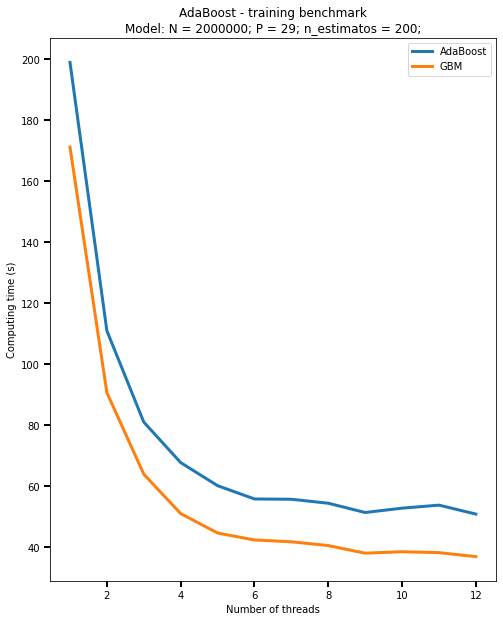

In [7]:
plot_result(adaboost_time, gbm_time)

In [8]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/lending-club/loan.csv", "bad_loan")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwako9tpe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwako9tpe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwako9tpe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_bofbys
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 11.285088777542114s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.5353288650512695s
H2O session _sid_96d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj_x88mxf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj_x88mxf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj_x88mxf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_bdcq9z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.154643535614014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.160421371459961s
H2O session _sid_a24d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyikzwqem
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyikzwqem\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyikzwqem\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_mv3ybt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.88744568824768s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.573832988739014s
H2O session _sid_b0ef closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3e3urten
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3e3urten\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3e3urten\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_34mg9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.230844497680664s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.8818042278289795s
H2O session _sid_a06b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8w2t288d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8w2t288d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8w2t288d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_sq1ubj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.230448246002197s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.572981357574463s
H2O session _sid_aa7b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu7azgjrg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu7azgjrg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu7azgjrg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_kn7zsm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 11.093926429748535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.505255222320557s
H2O session _sid_9b69 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6toyo3n8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6toyo3n8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6toyo3n8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_jxam20
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 11.157678604125977s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.900045394897461s
H2O session _sid_8a05 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj_0pdl2k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj_0pdl2k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj_0pdl2k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_kwixxd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.12827444076538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.610507011413574s
H2O session _sid_9de0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi9mnoyu4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi9mnoyu4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi9mnoyu4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_bt5s36
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.094427347183228s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.8534181118011475s
H2O session _sid_aac4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsm3gfqb8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsm3gfqb8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsm3gfqb8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_6m66ml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 11.473895788192749s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.544068336486816s
H2O session _sid_af9b closed.
AdaBoost 12.073667335510255s
IF 4.813766288757324s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpugsf29eo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpugsf29eo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpugsf29eo\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_gvtugf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.065209150314331s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.6829729080200195s
H2O session _sid_b944 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpowedm_r_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpowedm_r_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpowedm_r_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_zhtstf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.16425371170044s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.747538089752197s
H2O session _sid_ad24 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx7loqc_m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx7loqc_m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx7loqc_m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_e7w79k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.803849697113037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.2086334228515625s
H2O session _sid_aa4c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp70v5mtq9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp70v5mtq9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp70v5mtq9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_kibiaw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.95106053352356s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.28777289390564s
H2O session _sid_bd75 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqsfx48tj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqsfx48tj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqsfx48tj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_kazqfz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.369892835617065s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.35245943069458s
H2O session _sid_a208 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphlfpb6wn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphlfpb6wn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphlfpb6wn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_1k84te
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.270722389221191s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.5992271900177s
H2O session _sid_ae8d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6m34eq_c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6m34eq_c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6m34eq_c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,9 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_dj6lr7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.947684526443481s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.813438177108765s
H2O session _sid_b8b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphuozgom5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphuozgom5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphuozgom5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours
H2O_cluster_name:,H2O_from_python_potte_k08fnx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.10561990737915s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.0657806396484375s
H2O session _sid_abe8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6umpephp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6umpephp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6umpephp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours
H2O_cluster_name:,H2O_from_python_potte_3hehsa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.005640983581543s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.279428482055664s
H2O session _sid_aad7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1nehqgu8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1nehqgu8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1nehqgu8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_m8b8gq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.67203950881958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.842679023742676s
H2O session _sid_9bd6 closed.
AdaBoost 9.035597324371338s
IF 5.587993025779724s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0fmhqdss
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0fmhqdss\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0fmhqdss\h2o_potte_started_from_python.err
  Server is running at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_y85jte
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.986046314239502s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.258707761764526s
H2O session _sid_9c67 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpntwvxobt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpntwvxobt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpntwvxobt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_fnwiox
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.200524091720581s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.092436075210571s
H2O session _sid_8337 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp82sd98_w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp82sd98_w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp82sd98_w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_kn0thu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.979482412338257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.062197923660278s
H2O session _sid_8069 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg7e3l7qq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg7e3l7qq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg7e3l7qq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_ufujjg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.766405820846558s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.547195196151733s
H2O session _sid_ae6a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpim44ldu7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpim44ldu7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpim44ldu7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_oq86fn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.932006359100342s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.913314580917358s
H2O session _sid_8717 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_9dd3y_8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_9dd3y_8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_9dd3y_8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_x6nchj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.24151349067688s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.003716707229614s
H2O session _sid_b36c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkoqo7sqn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkoqo7sqn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkoqo7sqn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_lqklrs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.047921180725098s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.895557165145874s
H2O session _sid_8053 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsb648qts
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsb648qts\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsb648qts\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_eawf8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.032743215560913s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.799587726593018s
H2O session _sid_b597 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmj5rexaf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmj5rexaf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmj5rexaf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_l6it45
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.7316648960113525s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.092538595199585s
H2O session _sid_98f6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpez7ydb2f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpez7ydb2f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpez7ydb2f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_vo61sv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.869690418243408s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.323626279830933s
H2O session _sid_8e35 closed.
AdaBoost 8.078799819946289s
IF 5.098887801170349s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8jsat8s4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8jsat8s4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8jsat8s4\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_8u02fz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.832561492919922s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.511465549468994s
H2O session _sid_9788 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjlqoi86w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjlqoi86w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjlqoi86w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_5gaq8i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.901400327682495s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.012207269668579s
H2O session _sid_8c9b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqmf3s69p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqmf3s69p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqmf3s69p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_rrj3v0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.84249210357666s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.241700887680054s
H2O session _sid_995b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd_45sb53
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd_45sb53\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd_45sb53\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_e017gw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.81427001953125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.4300596714019775s
H2O session _sid_ad53 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpot1lc99m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpot1lc99m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpot1lc99m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_fnwixt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.8770740032196045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.428273677825928s
H2O session _sid_bbf8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc6hc4v4l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc6hc4v4l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc6hc4v4l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_98fyls
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.070971488952637s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.707940340042114s
H2O session _sid_beda closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5b539mve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5b539mve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5b539mve\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_v3ho0o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.730751037597656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.48856782913208s
H2O session _sid_a5d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpys15fj8d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpys15fj8d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpys15fj8d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_d2b0z3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.848463773727417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.764231204986572s
H2O session _sid_8699 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpryp3d35r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpryp3d35r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpryp3d35r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_aixmi8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.932329416275024s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.933951377868652s
H2O session _sid_9e52 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9y1phuak
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9y1phuak\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9y1phuak\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_9recav
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.9866533279418945s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.825645446777344s
H2O session _sid_a3d5 closed.
AdaBoost 7.683696699142456s
IF 4.63440432548523s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu1c9o42u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu1c9o42u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu1c9o42u\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_zq3q84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.917994976043701s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.649213790893555s
H2O session _sid_b390 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpchn88ijh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpchn88ijh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpchn88ijh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_kkfwl6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.880136251449585s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.588887929916382s
H2O session _sid_889e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdotceb48
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdotceb48\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdotceb48\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_fpc1im
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.801548957824707s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.409318923950195s
H2O session _sid_8eac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpttif94_k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpttif94_k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpttif94_k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_4i622v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.632516384124756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.461493730545044s
H2O session _sid_a4ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe6hw8js6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe6hw8js6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe6hw8js6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_v3ccnk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.779324769973755s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.554736137390137s
H2O session _sid_9434 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkaottgad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkaottgad\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkaottgad\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_hot01x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.732730150222778s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.1586384773254395s
H2O session _sid_9c5c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkddk2uez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkddk2uez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkddk2uez\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_hqqmsq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.6634674072265625s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.140754222869873s
H2O session _sid_b8ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqys74ter
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqys74ter\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqys74ter\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_h1rwnp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.432814359664917s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.909358978271484s
H2O session _sid_bc74 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgu77l5le
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgu77l5le\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgu77l5le\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_f0qdc2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.748708963394165s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.64421534538269s
H2O session _sid_8a55 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8h1_5vso
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8h1_5vso\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8h1_5vso\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_6hxgby
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.071457862854004s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.524430751800537s
H2O session _sid_9957 closed.
AdaBoost 7.866070008277893s
IF 4.604104828834534s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpye89bjmn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpye89bjmn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpye89bjmn\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_28vboi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.874674558639526s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.477736473083496s
H2O session _sid_aaf5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9jh8ariu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9jh8ariu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9jh8ariu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_6x2a8s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.679614782333374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.5895774364471436s
H2O session _sid_b36a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5s17mo6g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5s17mo6g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5s17mo6g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_xw8xjw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.732487440109253s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.422516584396362s
H2O session _sid_9310 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpojxqcqh3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpojxqcqh3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpojxqcqh3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_v6kqac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.54928994178772s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.1705474853515625s
H2O session _sid_a694 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn4nvc8jf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn4nvc8jf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn4nvc8jf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_3xo14e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.737897872924805s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.1335930824279785s
H2O session _sid_a796 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpknkydkzs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpknkydkzs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpknkydkzs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_m9dud7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.655549049377441s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.395036697387695s
H2O session _sid_926f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd5hjt9y_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd5hjt9y_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd5hjt9y_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_rnb7pa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.587802171707153s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.351182222366333s
H2O session _sid_a640 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa5re_4cu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa5re_4cu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa5re_4cu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_941ouw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.749186515808105s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.599675416946411s
H2O session _sid_a090 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5682irp_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5682irp_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5682irp_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_48gq18
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.780428647994995s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.467519283294678s
H2O session _sid_9cd9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdrtvwg6v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdrtvwg6v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdrtvwg6v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_s766jl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.7483532428741455s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.517507553100586s
H2O session _sid_b71b closed.
AdaBoost 7.809528422355652s
IF 4.412489223480224s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_qwbe4qq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_qwbe4qq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_qwbe4qq\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_nqpu0w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.887075662612915s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.688227653503418s
H2O session _sid_8ef3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4m6adikl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4m6adikl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4m6adikl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_udsch7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.499055624008179s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.331506967544556s
H2O session _sid_8d17 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8g1tc5r6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8g1tc5r6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8g1tc5r6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_ked7tl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.732806205749512s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.545159578323364s
H2O session _sid_8cbf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8eajmfci
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8eajmfci\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8eajmfci\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_7jvl0r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.392759799957275s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.130102634429932s
H2O session _sid_a763 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuw3sq80u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuw3sq80u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuw3sq80u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_ijdl0k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.737748384475708s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.642703533172607s
H2O session _sid_af0c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwxjkfdj4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwxjkfdj4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwxjkfdj4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_4qm2c8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.448285341262817s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.5590221881866455s
H2O session _sid_8682 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf_bvp62s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf_bvp62s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf_bvp62s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_xl9meo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.383200407028198s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.967390537261963s
H2O session _sid_a3d4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph432byd7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph432byd7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph432byd7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_dd07bo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.733158826828003s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.3036229610443115s
H2O session _sid_96ab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2k7aseib
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2k7aseib\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2k7aseib\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_bgdjwj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.849170446395874s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.377811670303345s
H2O session _sid_97f6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfi5mnzia
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfi5mnzia\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfi5mnzia\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_hidxfx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.751079082489014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.956660270690918s
H2O session _sid_9cea closed.
AdaBoost 8.24143397808075s
IF 4.450220799446106s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6cg52xzj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6cg52xzj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6cg52xzj\h2o_potte_started_from_python.err
  Server is running at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_5h5drr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.8258056640625s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.181707382202148s
H2O session _sid_b078 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8hmqb2ax
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8hmqb2ax\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8hmqb2ax\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_ae2d7m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.671294927597046s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.6744353771209717s
H2O session _sid_82a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdmqjh98f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdmqjh98f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdmqjh98f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_zvsj87
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.8882737159729s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.266420364379883s
H2O session _sid_9196 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgjl6nu6v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgjl6nu6v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgjl6nu6v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_uhu80g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.536824464797974s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.993650197982788s
H2O session _sid_8999 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpab_ahpc4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpab_ahpc4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpab_ahpc4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_y7gk30
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.7711851596832275s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.0212016105651855s
H2O session _sid_88dc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp656_o7gy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp656_o7gy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp656_o7gy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_trafed
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.542683601379395s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.234949588775635s
H2O session _sid_a577 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvjjudafm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvjjudafm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvjjudafm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_yq0xjp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.760005474090576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.18158221244812s
H2O session _sid_8cb8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1pm8imva
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1pm8imva\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1pm8imva\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_fot0yz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.833319902420044s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.033263206481934s
H2O session _sid_b108 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw1mv9c9f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw1mv9c9f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw1mv9c9f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_ikq3qg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.788985967636108s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.8125507831573486s
H2O session _sid_a419 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptedz5e1h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptedz5e1h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptedz5e1h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_2x3m0l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.801459550857544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.077290296554565s
H2O session _sid_af78 closed.
AdaBoost 8.24198384284973s
IF 4.147705101966858s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo18gmqh0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo18gmqh0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo18gmqh0\h2o_potte_started_from_python.err
  Server is running at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_j6hp89
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.573527097702026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.123535633087158s
H2O session _sid_95fe closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprkkwc8o5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprkkwc8o5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprkkwc8o5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_mzq31f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.758344650268555s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.095155715942383s
H2O session _sid_b0be closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ljdednl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ljdednl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ljdednl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_4m200n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.619473457336426s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.882747411727905s
H2O session _sid_8fef closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyk3lbtq1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyk3lbtq1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyk3lbtq1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_htu6zu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.62251615524292s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.089972019195557s
H2O session _sid_93f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwixa3cpc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwixa3cpc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwixa3cpc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_5cpnhd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.688184976577759s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.073810577392578s
H2O session _sid_b1f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1zg3u9uy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1zg3u9uy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1zg3u9uy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_oa0444
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.701227188110352s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.682557821273804s
H2O session _sid_bb61 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpenxe0qhv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpenxe0qhv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpenxe0qhv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_sqtk0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.984703302383423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.381627559661865s
H2O session _sid_bdb3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv69y6gne
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv69y6gne\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv69y6gne\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_hu9b5b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 8.804576396942139s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.856386661529541s
H2O session _sid_946c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjxfoe9_h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjxfoe9_h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjxfoe9_h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_bv5gh5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.420262575149536s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.141077995300293s
H2O session _sid_b8b7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprrjpdgt5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprrjpdgt5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprrjpdgt5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_qw6oqf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.767653465270996s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.091174840927124s
H2O session _sid_bba5 closed.
AdaBoost 8.994046926498413s
IF 4.341804623603821s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr00_pi6d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr00_pi6d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr00_pi6d\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_fo020q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.713847398757935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.9674530029296875s
H2O session _sid_9cd4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_pgukxqa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_pgukxqa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_pgukxqa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_gikd3j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 9.779948949813843s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.8201398849487305s
H2O session _sid_949c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpebwev32c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpebwev32c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpebwev32c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_8ehja3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.794230222702026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.756726026535034s
H2O session _sid_807d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplty_snqu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplty_snqu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplty_snqu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_dzjdr0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.74410343170166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.838597297668457s
H2O session _sid_9574 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp84u1re65
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp84u1re65\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp84u1re65\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_htvo7v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.771732568740845s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.889468669891357s
H2O session _sid_ba90 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw1g8jo5m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw1g8jo5m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw1g8jo5m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_sx3dys
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.764723300933838s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.963795900344849s
H2O session _sid_a3a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66qw7a2t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66qw7a2t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66qw7a2t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_kd317j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.460964679718018s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.91868257522583s
H2O session _sid_93b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp216m5j0q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp216m5j0q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp216m5j0q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_vr1ror
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.761181831359863s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.56568169593811s
H2O session _sid_bfbe closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnc2038ut
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnc2038ut\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnc2038ut\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_drzhig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.958935499191284s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.794291257858276s
H2O session _sid_b2de closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmhpxguq5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmhpxguq5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmhpxguq5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_0czkzs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.467565298080444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.797192811965942s
H2O session _sid_a3fb closed.
AdaBoost 10.621723318099976s
IF 4.931202912330628s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzqac5_wd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzqac5_wd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzqac5_wd\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_0awrwb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.024420022964478s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.861931324005127s
H2O session _sid_8bc7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7szdmta3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7szdmta3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7szdmta3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_y58hvw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.803073406219482s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.850323438644409s
H2O session _sid_95a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph_3xa8ue
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph_3xa8ue\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph_3xa8ue\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,10 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_g921tf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.096691608428955s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.333847761154175s
H2O session _sid_bd72 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppg3cceot
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppg3cceot\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppg3cceot\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours
H2O_cluster_name:,H2O_from_python_potte_hmle1o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.769287347793579s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.832750082015991s
H2O session _sid_bdd2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppgi7b9ob
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppgi7b9ob\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppgi7b9ob\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_to3ze9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.017041444778442s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.815239429473877s
H2O session _sid_b460 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp291ycd5e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp291ycd5e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp291ycd5e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_0bom3t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.09195327758789s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.5493690967559814s
H2O session _sid_89ed closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0hddhhu5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0hddhhu5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0hddhhu5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_2jhl8o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.108642101287842s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.445454120635986s
H2O session _sid_b246 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp87yx_l0o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp87yx_l0o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp87yx_l0o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_ajjyyh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.080663204193115s
gbm Model Build progress: |█████████████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.488634824752808s
H2O session _sid_99eb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8_iv6wcq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8_iv6wcq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8_iv6wcq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_3l7xji
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.04268193244934s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.4722936153411865s
H2O session _sid_971a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprne0myv4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprne0myv4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprne0myv4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_yfjnra
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.931263446807861s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.413640260696411s
H2O session _sid_afd7 closed.
AdaBoost 12.696571779251098s
IF 6.206348395347595s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66v_a953
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66v_a953\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66v_a953\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_b9qpl1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.700072765350342s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.362722158432007s
H2O session _sid_ac1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvfybye97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvfybye97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvfybye97\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_9ta2c3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.35032320022583s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.863328695297241s
H2O session _sid_9637 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ju3wpa8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ju3wpa8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ju3wpa8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_opzef0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.58595371246338s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.400396347045898s
H2O session _sid_ac29 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd6mtegy4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd6mtegy4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd6mtegy4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_bw3i4k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.752134084701538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.548504829406738s
H2O session _sid_bc8a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyk8t1cc_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyk8t1cc_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyk8t1cc_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_mfro5m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.892773866653442s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.389594316482544s
H2O session _sid_89a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmnckq8mg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmnckq8mg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmnckq8mg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_32xfy0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.679925203323364s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.354469537734985s
H2O session _sid_afef closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp13iuhjbr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp13iuhjbr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp13iuhjbr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_qf4twy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.679677486419678s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.555294036865234s
H2O session _sid_9ea4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc3aaghs1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc3aaghs1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc3aaghs1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_2gpt42
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.057645559310913s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.363478422164917s
H2O session _sid_992e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2ugdvocp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2ugdvocp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2ugdvocp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_i4gkdz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.805026054382324s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.396416425704956s
H2O session _sid_afca closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwdy5s0bi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwdy5s0bi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwdy5s0bi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_tgx09h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.427457809448242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.46140456199646s
H2O session _sid_8770 closed.
AdaBoost 20.393098974227904s
IF 10.269560933113098s
12 - AdaBoost = 12.073667335510255, GBM = 4.813766288757324
11 - AdaBoost = 9.035597324371338, GBM = 5.587993025779724
10 - AdaBoost = 8.078799819946289, GBM = 5.098887801170349
9 - AdaBoost = 7.683696699142456, GBM = 4.63440432548523
8 - AdaBoost = 7.866070008277893, GBM = 4.604104828834534
7 - AdaBoost = 7.809528422355652, GBM = 4.412489223480224
6 - AdaBoost = 8.24143397808075, GBM = 4.450220799446106
5 - AdaBoost = 8.24198384284973, GBM = 4.147705101966858
4 - AdaBoost = 8.994046926498413, GBM = 4.341804623603821
3 - AdaBoost = 10.621723318099976, GBM = 4.931

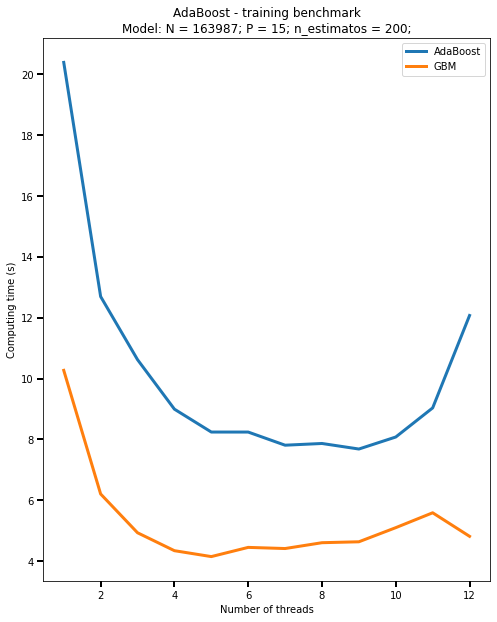

In [9]:
plot_result(adaboost_time, gbm_time)

In [10]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/creditcardfraud/creditcardfraud.csv", "Class")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp69d4cqdg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp69d4cqdg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp69d4cqdg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_np3u4h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.71752119064331s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.3394935131073s
H2O session _sid_968e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp26jclwd9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp26jclwd9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp26jclwd9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_5lq708
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.790858507156372s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.131666660308838s
H2O session _sid_b237 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp65n49vy4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp65n49vy4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp65n49vy4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_zwhose
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.67427134513855s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.89359188079834s
H2O session _sid_9b18 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1oo33hrc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1oo33hrc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1oo33hrc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_kej9le
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.817018032073975s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.322699308395386s
H2O session _sid_9db5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp__1auvln
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp__1auvln\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp__1auvln\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_3c87g5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.82428526878357s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.120957136154175s
H2O session _sid_aa4d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbr3bp0dr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbr3bp0dr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbr3bp0dr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_y8eryy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.373056411743164s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.1675193309783936s
H2O session _sid_b77f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplko1hq1e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplko1hq1e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplko1hq1e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_wiw8ts
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.60230827331543s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.193633079528809s
H2O session _sid_86fc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ejykgv5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ejykgv5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ejykgv5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_92xjef
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.854583501815796s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.373277425765991s
H2O session _sid_aea9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkuk6m6gv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkuk6m6gv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkuk6m6gv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_959iez
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.78286075592041s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.265165090560913s
H2O session _sid_9095 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplxqmvqba
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplxqmvqba\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplxqmvqba\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_nnbt6c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.930879592895508s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.6839094161987305s
H2O session _sid_a7d5 closed.
AdaBoost 16.13676428794861s
IF 7.049191284179687s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy8emlweo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy8emlweo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy8emlweo\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_w4b0ck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.229253053665161s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.130581617355347s
H2O session _sid_b71f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_0l1hqma
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_0l1hqma\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_0l1hqma\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_jlw58m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.72087049484253s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.93250584602356s
H2O session _sid_9a4c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9cixqw0g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9cixqw0g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9cixqw0g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_1rb9mw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.57461667060852s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.88105845451355s
H2O session _sid_88ae closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx_o7oojq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx_o7oojq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx_o7oojq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_uejbs1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.826784372329712s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.076115608215332s
H2O session _sid_9f09 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp6v5aem_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp6v5aem_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp6v5aem_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_hkn2ck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.99218487739563s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.053788900375366s
H2O session _sid_a9fc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc1pv98os
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc1pv98os\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc1pv98os\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_jwfuu3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.190659046173096s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.909611463546753s
H2O session _sid_9533 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy81nb852
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy81nb852\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy81nb852\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_awlx2e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.783517599105835s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.782109260559082s
H2O session _sid_9fbd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp595l30u8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp595l30u8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp595l30u8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_gwg8nj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.253685474395752s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.833712100982666s
H2O session _sid_b0c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu5yne4i0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu5yne4i0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu5yne4i0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_dsmyon
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.757184982299805s
gbm Model Build progress: |█████████████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.643765449523926s
H2O session _sid_8945 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6xujd1cl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6xujd1cl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6xujd1cl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O serve

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_51lrlg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.733486890792847s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.048308849334717s
H2O session _sid_9b5e closed.
AdaBoost 13.406224346160888s
IF 6.12915575504303s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_fd5r78q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_fd5r78q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_fd5r78q\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_2dnlei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.825627326965332s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.953116178512573s
H2O session _sid_b462 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5uq2rwqk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5uq2rwqk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5uq2rwqk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_peuuo8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.739203691482544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.84547758102417s
H2O session _sid_ae08 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9w30hl_y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9w30hl_y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9w30hl_y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_pe6qrt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.706874132156372s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.485168218612671s
H2O session _sid_84d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp69rtotgz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp69rtotgz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp69rtotgz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_jzkgz7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.12450885772705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.889051675796509s
H2O session _sid_8e5c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9c8okd96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9c8okd96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9c8okd96\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_j1l7rb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.323354244232178s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.746475458145142s
H2O session _sid_b53b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjki4zkep
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjki4zkep\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjki4zkep\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_lo1tgc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.23516035079956s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.817713737487793s
H2O session _sid_af2d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvte0tnev
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvte0tnev\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvte0tnev\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_1ovk81
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.537071704864502s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.74591588973999s
H2O session _sid_9a16 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuop9fhhg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuop9fhhg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuop9fhhg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_mvsg3r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.857064723968506s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.776622295379639s
H2O session _sid_be3c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq30uckhw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq30uckhw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq30uckhw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_q02wv5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.013298273086548s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.882527112960815s
H2O session _sid_8473 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb69s7t_i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb69s7t_i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb69s7t_i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_9q5axw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.633938550949097s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.046108245849609s
H2O session _sid_8c38 closed.
AdaBoost 13.29961018562317s
IF 6.918817639350891s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzj0e2yi3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzj0e2yi3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzj0e2yi3\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_mnzlti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.595702648162842s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.367109775543213s
H2O session _sid_be4e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp17_tbmxw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp17_tbmxw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp17_tbmxw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_1q55fp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.669580698013306s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.7432732582092285s
H2O session _sid_b115 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpix0zw_9v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpix0zw_9v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpix0zw_9v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_hc1a1c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.986892461776733s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.793328762054443s
H2O session _sid_bdb8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnps535hs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnps535hs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnps535hs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_pgl77v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.088207244873047s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.437909364700317s
H2O session _sid_bcf9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv24lm2kg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv24lm2kg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv24lm2kg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_fiioo4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.16922402381897s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.466167688369751s
H2O session _sid_8da6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp48nu_vnw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp48nu_vnw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp48nu_vnw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_mtg0vi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 11.951111316680908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.810783386230469s
H2O session _sid_928f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppldlen4t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppldlen4t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppldlen4t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_vkfcyj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.008751630783081s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.463261127471924s
H2O session _sid_b887 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbdexhogu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbdexhogu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbdexhogu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_7qrb0h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.149976968765259s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.72951340675354s
H2O session _sid_a798 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkxjxvsxf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkxjxvsxf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkxjxvsxf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_1rkn1k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.905431509017944s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.814799785614014s
H2O session _sid_b534 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq4_musup
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq4_musup\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq4_musup\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_hdzehe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.551476955413818s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.284613847732544s
H2O session _sid_99c2 closed.
AdaBoost 12.50763554573059s
IF 6.591076040267945s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8s8sc2ua
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8s8sc2ua\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8s8sc2ua\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_ygipxs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.974676370620728s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.261803150177002s
H2O session _sid_8c43 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8azp_cyc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8azp_cyc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8azp_cyc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_tmlsz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.003214120864868s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.318817138671875s
H2O session _sid_a85d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_0jruzzf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_0jruzzf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_0jruzzf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_m504n1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.805247068405151s
gbm Model Build progress: |██████████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.342102289199829s
H2O session _sid_bec1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvkjwukwp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvkjwukwp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvkjwukwp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_48mi8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.998334646224976s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.313150644302368s
H2O session _sid_b544 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1db9u9nv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1db9u9nv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1db9u9nv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_oiot58
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.929657459259033s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.4019458293914795s
H2O session _sid_a2fc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmp670bll
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmp670bll\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmp670bll\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_1ccbs1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.29625129699707s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.339046955108643s
H2O session _sid_b8f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpre0_ufzb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpre0_ufzb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpre0_ufzb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_13zwpw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.969735622406006s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.417622089385986s
H2O session _sid_8209 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpecg2fe2i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpecg2fe2i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpecg2fe2i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_hgkku8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.741345882415771s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.340075731277466s
H2O session _sid_b7e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfvjeis6j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfvjeis6j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfvjeis6j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_m9294s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.956095695495605s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.295702695846558s
H2O session _sid_9472 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpftmlib6z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpftmlib6z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpftmlib6z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_ls3tdf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.84346866607666s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.927925109863281s
H2O session _sid_89e0 closed.
AdaBoost 12.851802682876587s
IF 7.295819163322449s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm0wt5zmp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm0wt5zmp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm0wt5zmp\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_86m40k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.304869174957275s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.359215974807739s
H2O session _sid_8489 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4yidg36c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4yidg36c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4yidg36c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_wjpm2z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.094034910202026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.5681493282318115s
H2O session _sid_930d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5qsx7bus
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5qsx7bus\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5qsx7bus\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_1pempc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.007710933685303s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.605743646621704s
H2O session _sid_8b68 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt_3cmeow
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt_3cmeow\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt_3cmeow\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_l2fbyo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.265049695968628s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.468048095703125s
H2O session _sid_9035 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkwwxpks4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkwwxpks4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkwwxpks4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,11 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_3u6asc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.154809713363647s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.602763891220093s
H2O session _sid_bf32 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl77ihz5h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl77ihz5h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl77ihz5h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours
H2O_cluster_name:,H2O_from_python_potte_j2hik1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.137980937957764s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.431197166442871s
H2O session _sid_a22a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu8x1k8hh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu8x1k8hh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu8x1k8hh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_2wn92s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.02625060081482s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.5626397132873535s
H2O session _sid_87b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoasecsn9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoasecsn9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoasecsn9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_ewhi5n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.893366575241089s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.363950729370117s
H2O session _sid_af5d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvmqy1oau
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvmqy1oau\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvmqy1oau\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_mk2aju
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.067458868026733s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.517786502838135s
H2O session _sid_b549 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplvqe7ic5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplvqe7ic5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplvqe7ic5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_g941qy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.066721200942993s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.3532984256744385s
H2O session _sid_826c closed.
AdaBoost 12.801825261116027s
IF 6.983279347419739s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxjni11zx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxjni11zx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxjni11zx\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_l59hwb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.274816989898682s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.568420648574829s
H2O session _sid_9ff8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu5z2g96a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu5z2g96a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu5z2g96a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_p8dbf4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.808039665222168s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.6689934730529785s
H2O session _sid_b385 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpep_fuzm_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpep_fuzm_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpep_fuzm_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_6ar2nb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.140433073043823s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.498429298400879s
H2O session _sid_a61f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprt3s440
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprt3s440\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprt3s440\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_bkkvey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.858371496200562s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.609030485153198s
H2O session _sid_951b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmposum20po
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmposum20po\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmposum20po\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_fy5f8b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.303776979446411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.6787872314453125s
H2O session _sid_acb7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8wfbbrdv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8wfbbrdv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8wfbbrdv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_767i9f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.030802488327026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.360985517501831s
H2O session _sid_97ef closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpii26nzp5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpii26nzp5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpii26nzp5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_9z66vf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.863673448562622s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.540316820144653s
H2O session _sid_b9ac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpio2s8ooq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpio2s8ooq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpio2s8ooq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_tn629e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 13.321959495544434s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.632818222045898s
H2O session _sid_9e6b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9fujjog_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9fujjog_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9fujjog_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_m9wxes
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.177967548370361s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.636864423751831s
H2O session _sid_be53 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmkll7ir1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmkll7ir1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmkll7ir1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_f9baox
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 12.833794116973877s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.505981922149658s
H2O session _sid_b915 closed.
AdaBoost 13.561363530158996s
IF 7.670062804222107s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0i56o7t2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0i56o7t2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0i56o7t2\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_bhrb5h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.046217679977417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.44558572769165s
H2O session _sid_af20 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphc2qs06k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphc2qs06k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphc2qs06k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_hxbl0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.08316683769226s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.267146348953247s
H2O session _sid_aa1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4a_20fxw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4a_20fxw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4a_20fxw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_2q2vj7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.150157690048218s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.226088523864746s
H2O session _sid_b2e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8uli8ft_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8uli8ft_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8uli8ft_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_7qeen7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.11126160621643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.281184434890747s
H2O session _sid_8f7f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpci7bw3xk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpci7bw3xk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpci7bw3xk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_n6lowx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.298571586608887s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.249534130096436s
H2O session _sid_a20f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvcnnljym
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvcnnljym\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvcnnljym\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_3ve9qt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.822824716567993s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.239089488983154s
H2O session _sid_a8c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpddat09zc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpddat09zc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpddat09zc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_z455pc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.154200315475464s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.22620677947998s
H2O session _sid_b151 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzmdrvp3m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzmdrvp3m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzmdrvp3m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_339rj3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.216969728469849s
gbm Model Build progress: |█████████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.241148471832275s
H2O session _sid_b8b6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3xf_a5k3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3xf_a5k3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3xf_a5k3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_eycp0h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.176400661468506s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.187390565872192s
H2O session _sid_ba62 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkwemvk79
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkwemvk79\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkwemvk79\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_b7in07
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.189921617507935s
gbm Model Build progress: |██████████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.236874103546143s
H2O session _sid_b512 closed.
AdaBoost 14.324969244003295s
IF 8.260024857521056s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpafz5ocgs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpafz5ocgs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpafz5ocgs\h2o_potte_started_from_python.err
  Server is running a

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_5ddrk0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.5453462600708s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.362393379211426s
H2O session _sid_a7a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsrm2x4h5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsrm2x4h5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsrm2x4h5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_7zikcc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.069494485855103s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.497580289840698s
H2O session _sid_9568 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp05zfzem_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp05zfzem_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp05zfzem_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_d10gnn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.268326044082642s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.521688461303711s
H2O session _sid_96bb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxawf60jr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxawf60jr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxawf60jr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_cogymn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.058004140853882s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.473889827728271s
H2O session _sid_8fd7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyl5n064d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyl5n064d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyl5n064d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_mrrdi3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.09846305847168s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.461501598358154s
H2O session _sid_ad72 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphoqrbgda
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphoqrbgda\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphoqrbgda\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_35o439
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.797929525375366s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.57728624343872s
H2O session _sid_835e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl5mtjdtw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl5mtjdtw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl5mtjdtw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_lbiymd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.194337129592896s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.457593202590942s
H2O session _sid_9605 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzg1i088b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzg1i088b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzg1i088b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_c018hi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.376012563705444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.423826217651367s
H2O session _sid_b6d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1gbelzwx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1gbelzwx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1gbelzwx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_5lyxlg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.213848114013672s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.45951533317566s
H2O session _sid_8027 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgnbzw1mi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgnbzw1mi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgnbzw1mi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_q3yf6w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.179969310760498s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.535086870193481s
H2O session _sid_aad7 closed.
AdaBoost 14.380173063278198s
IF 8.577036142349243s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoz3845_i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoz3845_i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoz3845_i\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_x6l74c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.404054880142212s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.478397130966187s
H2O session _sid_b082 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp78d35dsp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp78d35dsp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp78d35dsp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_605hds
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.416182279586792s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.589672327041626s
H2O session _sid_acdc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk_q_ymw_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk_q_ymw_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk_q_ymw_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_q8w0b6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.57070565223694s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.787431240081787s
H2O session _sid_b9ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt1t4dcb2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt1t4dcb2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt1t4dcb2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_0rnnia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.363502979278564s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.326674699783325s
H2O session _sid_b449 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvx77gqhr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvx77gqhr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvx77gqhr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_h1emdj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.611306190490723s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.397190809249878s
H2O session _sid_b218 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdk1az2_d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdk1az2_d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdk1az2_d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_5f7k9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.326748847961426s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.826400995254517s
H2O session _sid_81cc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0hjfkw4c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0hjfkw4c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0hjfkw4c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_gd0ife
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.558408975601196s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.692023754119873s
H2O session _sid_8097 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66r6vzj2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66r6vzj2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66r6vzj2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_rccbo8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.260883569717407s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.778273105621338s
H2O session _sid_910b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz7h0c2vw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz7h0c2vw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz7h0c2vw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_5lxdmc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.431963443756104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.34348201751709s
H2O session _sid_81cd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphism7gfu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphism7gfu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphism7gfu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_ij783s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.465500831604004s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.362141370773315s
H2O session _sid_b11b closed.
AdaBoost 17.440925765037537s
IF 11.058168745040893s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaghg08dl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaghg08dl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaghg08dl\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_c8gfab
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 23.951292991638184s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.795048236846924s
H2O session _sid_baa5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphbm9dpfc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphbm9dpfc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphbm9dpfc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_vp7a0b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 22.659299850463867s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.809218883514404s
H2O session _sid_8d89 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdegi6msw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdegi6msw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdegi6msw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_o5ki62
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 22.613098859786987s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.771301984786987s
H2O session _sid_b80b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkr827tg_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkr827tg_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkr827tg_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_ybf5p1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.956735610961914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.765663385391235s
H2O session _sid_be12 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphjqsnc1i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphjqsnc1i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphjqsnc1i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_i3qofu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.625308752059937s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.64892029762268s
H2O session _sid_b0b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0zaasryx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0zaasryx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0zaasryx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_pz8969
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.542081117630005s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.788398742675781s
H2O session _sid_af52 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3nx86um4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3nx86um4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3nx86um4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_9d2azq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.654518365859985s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.892951726913452s
H2O session _sid_b268 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwg0p2dci
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwg0p2dci\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwg0p2dci\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_hw71j5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 23.15725564956665s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.874883651733398s
H2O session _sid_b62f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplqy6xcfc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplqy6xcfc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplqy6xcfc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_8mi1y7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.997387409210205s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.814961671829224s
H2O session _sid_becc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeijsn7a8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeijsn7a8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeijsn7a8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_f69s9q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.992053031921387s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.802733659744263s
H2O session _sid_8f5c closed.
AdaBoost 22.31490316390991s
IF 15.296408224105836s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6a6cnyvw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6a6cnyvw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6a6cnyvw\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_67p2ip
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.534165382385254s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 29.321292638778687s
H2O session _sid_b4d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfmv9gkgw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfmv9gkgw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfmv9gkgw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_kkygk7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.346572160720825s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 29.979292154312134s
H2O session _sid_ac53 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwo0s379g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwo0s379g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwo0s379g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_mhuu47
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.41728496551514s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 30.114266633987427s
H2O session _sid_8e8a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe65xz59c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe65xz59c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe65xz59c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_i7qges
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.18145704269409s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 29.288180112838745s
H2O session _sid_9007 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcg28p4yg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcg28p4yg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcg28p4yg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_8gsnnm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 35.3503532409668s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 27.879629611968994s
H2O session _sid_b4a2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpryxlk5y6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpryxlk5y6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpryxlk5y6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,12 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_h8emhc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 36.51486277580261s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 27.224306106567383s
H2O session _sid_8079 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2zy6kfwc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2zy6kfwc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2zy6kfwc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,13 hours
H2O_cluster_name:,H2O_from_python_potte_l11o5t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 36.039026975631714s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 27.901511669158936s
H2O session _sid_8509 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpefegmha2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpefegmha2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpefegmha2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,13 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_0cge61
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.739482164382935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 29.47919464111328s
H2O session _sid_917e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcuakgplz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcuakgplz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcuakgplz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,13 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_69p9of
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.73482823371887s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 30.783519744873047s
H2O session _sid_9602 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwga4q1e1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwga4q1e1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwga4q1e1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,13 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_621qmd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.648383378982544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 29.408676624298096s
H2O session _sid_bc86 closed.
AdaBoost 38.05064163208008s
IF 29.137986993789674s
12 - AdaBoost = 16.13676428794861, GBM = 7.049191284179687
11 - AdaBoost = 13.406224346160888, GBM = 6.12915575504303
10 - AdaBoost = 13.29961018562317, GBM = 6.918817639350891
9 - AdaBoost = 12.50763554573059, GBM = 6.591076040267945
8 - AdaBoost = 12.851802682876587, GBM = 7.295819163322449
7 - AdaBoost = 12.801825261116027, GBM = 6.983279347419739
6 - AdaBoost = 13.561363530158996, GBM = 7.670062804222107
5 - AdaBoost = 14.324969244003295, GBM = 8.260024857521056
4 - AdaBoost = 14.380173063278198, GBM = 8.577036142349243
3 - AdaBoost = 17.440925765037537, GBM 

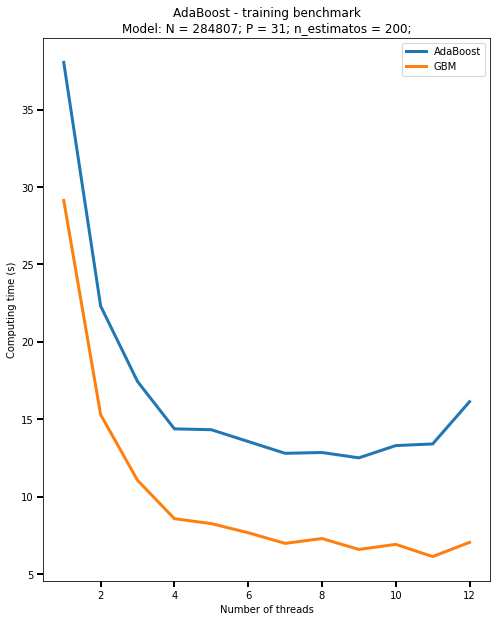

In [11]:
plot_result(adaboost_time, gbm_time)